## Random Forest Classifier for News dataset. 



In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime


In [30]:
import time
import os
import ast
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

import itertools
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords

In [31]:
from sklearn.metrics import confusion_matrix, f1_score

In [32]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [33]:
pd.options.display.max_columns
pd.set_option("display.max_columns",100)

### Import data

In [34]:
data = pd.read_csv('HIGHBROW-FB1.csv')

In [35]:
data.shape

(41902, 93)

In [36]:
def yules_ind(entry):
    """
    This function recieves a string (text) and computes its Yule's K and I
    Indices.
    the function is partialy based on Swizec Teller's blog post:
    "https://swizec.com/blog/measuring-vocabulary-richness-with-python/swizec/2528"
    """
    from nltk.stem.porter import PorterStemmer
    from itertools import groupby
    import sys
    
    def words(entry): # clean text from unnecessary characters
        return filter(lambda w: len(w),
                      [w.strip("0123456789!:,.?(){}[]") for w in entry.split()]) 

    def yule_param(entry): # stemm the text and creates a dictionary with counts of each word
        d = {}
        stemmer = PorterStemmer()
        for w in words(entry):
            w = stemmer.stem(w).lower()
            try:
                d[w] += 1
            except KeyError:
                d[w] = 1

        s1 = len(d)
        s2 = 0
        for i in range(1,max(d.values())+1):
            s2_iter=(i**2)*sum(1 for x in d.values() if x==i)
            s2 += s2_iter

        return (s1, s2)
    
    try:
        s1,s2 = yule_param(entry)
    except ValueError:
        print( "can't calculate indecise, text length is 0")
        sys.exit()
        
        
    yule_K = (10**4)*((s2-s1)/(s1**2)) # original Yule's K indices- The lower the index, the higher LD of the text
    #yule_I = 1/((s2-s1)/(s1**2))       # The inverse of Yule's K indices- more intuitive, The bigger the index, 
                                       ### the higher LD of the text
    return (yule_K)

In [37]:
data['Yule_K'] = data.body.map(lambda x: yules_ind(x))

In [38]:
data[['yuleK', 'yuleI']] = data['yule'].str.split(' ', n=1, expand=True)

In [39]:
data.yuleK = data.yuleK.replace('\(','', regex=True)

In [40]:
data.yuleK

0         37.82161234991423,
1        26.579096045197737,
2        30.427892234548334,
3        11.523499779673918,
4         9.900772495257465,
                ...         
41897    24.075156576200417,
41898     17.78638941398866,
41899    14.669477058601233,
41900     12.37336080929187,
41901         25.3134765625,
Name: yuleK, Length: 41902, dtype: object

In [41]:
data['yuleK'] = [float(str(val).replace(' ','').replace(',','')) for val in data['yuleK'].values]

In [42]:
data.yuleK

0        37.821612
1        26.579096
2        30.427892
3        11.523500
4         9.900772
           ...    
41897    24.075157
41898    17.786389
41899    14.669477
41900    12.373361
41901    25.313477
Name: yuleK, Length: 41902, dtype: float64

In [43]:
data.Yule_K

0         264.399093
1         376.235519
2         328.645833
3         867.791920
4        1010.022198
            ...     
41897     415.365938
41898     562.227654
41899     681.687558
41900     808.187861
41901     395.046487
Name: Yule_K, Length: 41902, dtype: float64

In [44]:
data.yule

0         (37.82161234991423, 264.39909297052156)
1         (26.579096045197737, 376.2355191837603)
2        (30.427892234548334, 328.64583333333337)
3         (11.523499779673918, 867.7919200934781)
4         (9.900772495257465, 1010.0221982466585)
                           ...                   
41897     (24.075156576200417, 415.3659382587582)
41898      (17.78638941398866, 562.2276543734722)
41899      (14.669477058601233, 681.687558462532)
41900      (12.37336080929187, 808.1878605277899)
41901         (25.3134765625, 395.04648740403536)
Name: yule, Length: 41902, dtype: object

In [45]:
data.yuleK.dtypes

dtype('float64')

In [46]:
from textblob import TextBlob, Word

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity


In [52]:
data['Title Polarity'] = data['Title'].apply(detect_polarity)

In [53]:
for i in range(data.shape[0]): 
    data.loc[i, "#title_words"] = int(len(data.loc[i, "Title"].split()))

In [54]:
# cursing 

curses = ["F–k", "F-U", "f—king", "s**t", "b******", "s***hole", "p****",
        "b****es", "a**hole", "Fuck you", "faggots", "Fag", "arse", "b****es", 
        "p**fs", "wh***", "B***h", "WTF", "f***", "f****ed", "c**t", "b***h", 
        "f--king", "N***a", "a***holes", "f****t", "p****", "N***a", "p***k", 
        "*******", "f***ing", "p*****", "b—h", "s***", "f***", "F***", "f---s", 
        "c**p", "thug", "n*******", "t**t", "p***","motherf***er", "f****t", 
        "n*****", "b*****d", "bulls**t", "a******s", "scumbag"]

def find_cursing(row):
    cursing = []
    count  =0
    # Split string by ', ', drop duplicates and join back.
    words = row.split(' ')
    #print(words)
    for i in words:
        if i in curses:
            
            cursing.append(i)
            count +=1 
    return count
                


# drop_duplicates is applied to all rows of df.
data['cursing'] = data['body'].apply(find_cursing)

In [61]:
data['Title cursing'] = data['Title'].apply(find_cursing)

In [56]:
#MESSAGE features
data =data[data['Message'].notna()]

In [58]:
data.shape

(36518, 99)

In [59]:
data['Message Polarity'] = data['Message'].apply(detect_polarity)

In [60]:
data['Message cursing'] = data['Message'].apply(find_cursing)

In [87]:
data['Message cursing'].value_counts()

0    36505
1       12
2        1
Name: Message cursing, dtype: int64

In [62]:
path = '../../LEXICONS/Subjectivity/subjclueslen1-HLTEMNLP05.tff'

l = open(path,'r').read().split('\n')

data1 = []
for val in l[0:-1]:
    typ = val.split()[0].split('=')[1]
    length = int(val.split()[1].split('=')[1])
    word = ' '.join(val.split()[2:2+length]).split('=')[1]
    vals = val.split()[2+length:]
    d = dict([i.split('=') for i in vals if len(i.split('='))==2])
    d.update({'w':word,'length':length,'type':typ})
    data1.append(d)

In [65]:
#Don't name your dataset df!!!!because it won't work!

#I need only the strong subj for my df
from collections import Counter
df = pd.DataFrame(data1)

subjectivity_types = list(df.type.unique())
w2subj = dict(df[['w','type']].values)
def get_strong_subjectivity(doc, tokenizer=nltk.word_tokenize,agg='mean'):
    if type(doc)==str:
        doc = tokenizer(doc)
    assert type(doc)==list,"please input either a list or a string"
    if len(doc)==0:
        return np.nan
    matches = Counter()
    for w in doc:
        w = w.lower()
        if w in w2subj:
            matches[w2subj[w]]+=1
    
    if len(matches)==0:
        return {typ:0 for typ in subjectivity_types}
    scores = pd.Series(np.array([matches[typ] for typ in subjectivity_types]),index=subjectivity_types)
    if agg=='mean':
        scores =  scores/len(doc)
    elif agg =='abs': 
        scores = scores
    else:
        scores =  agg(scores)
    return list(dict(scores).values())[1]

#pickle.dump([w2subj,subjectivity_types],open('lexicon_functions/subjectivity_score.pkl','wb'))
#w2subj,subjectivity_types = pickle.load(open('lexicon_functions/subjectivity_score.pkl','rb'))
get_strong_subjectivity('absolutely, i once kissed a boy and i liked it')

0.09090909090909091

In [67]:
data['Subjectivity Message'] = data['Message'].apply(lambda x: get_strong_subjectivity(x))

In [68]:
data['Subjectivity Title'] = data['Title'].apply(lambda x: get_strong_subjectivity(x))

In [70]:
#CAPS
import re
regex = r'\b[A-Z]{5,}\b'
data['Caps Title'] = data['Title'].str.findall(regex)
data['Caps Title'] =data['Caps Title'].str.len()

In [72]:
data['Caps Title'].value_counts()

0    30406
1     6105
2        7
Name: Caps Title, dtype: int64

In [73]:
data['Caps Message'] = data['Message'].str.findall(regex)
data['Caps Message'] =data['Caps Message'].str.len()

In [74]:
data['!'] = data['Message'].apply(lambda x: 1  if '!' in x else 0)

In [83]:
data['?'] = data['Message'].apply(lambda x: 1  if '?' in x else 0)

In [82]:
data['"'] = data['Message'].apply(lambda x: 1  if '"' in x else 0)

In [84]:
data['"'].value_counts()

0    32463
1     4055
Name: ", dtype: int64

In [88]:
#dff = data[data['"']==1]
#dff

In [89]:
data['Publication'].value_counts()
#Politico has no title!

NYT                9944
Independent        9678
Politico           7929
Washington Post    5309
Guardian           3658
Name: Publication, dtype: int64

In [52]:
#κανονικά δεν έχει μέσα NYT αλλα στις 18.10.22 εκανα ενα δευτερο dataset εδω για το facebook. 
#data = data[data['Publication']!= 'NYT']

In [55]:
data = data.drop(['adjectives', 'adverbs', 'verbs', 'nouns', 'properNouns','url', 'date', 'author', 'Title',
                  #'Noimages',
               'body', 'Publication', 'tokenized','yule', 'yuleI', 'yuleK', 'sensual','celebrities','animal', 'crime','URL', 
                'Message', 'Link', 'Final Link', 'Image Text', 'Link Text', 'Description'
               ], axis = 1)

In [90]:
#2
data = data.drop(['adjectives', 'adverbs', 'verbs', 'nouns', 'properNouns',
                  #'Noimages',
               'body', 'tokenized','yule', 'yuleI', 'yuleK', 'sensual','celebrities','animal', 'crime','URL', 
                'Final Link', 'Image Text', 'Link Text', 'Description'
               ], axis = 1)

In [91]:
data= data.dropna()

In [92]:
data['quality'] = 1

In [93]:
data.shape

(36518, 93)

In [94]:
data.head(3)

url  \
0  https://www.theguardian.com/world/2019/aug/06/...   
3  https://www.theguardian.com/world/2019/aug/06/...   
4  https://www.theguardian.com/world/2019/jul/30/...   

                        date                                    author  \
0   Tue 6 Aug 2019 14.47 BST  Tom Phillips Latin America correspondent   
3   Tue 6 Aug 2019 06.00 BST                           Caroline Fraser   
4  Tue 30 Jul 2019 06.00 BST                           Bernhard Warner   

                                               Title Noimages Publication  \
0  Brazil gang leader found dead in cell after ma...        2    Guardian   
3  Dying the Christian Science way: the horror of...        4    Guardian   
4  Boar wars: how wild hogs are trashing European...        6    Guardian   

   num_wds  difficulty  uniq_wds  char_count  avg_word  perc_uniq  avg_sent  \
0    361.0        47.0     225.0      2135.0  5.030137   0.623269  5.030137   
3   4761.0        54.0    1702.0     27720.0  4.986622   0.357488  4.986622   
4   5232.0        57.0    1837.0     30425.0  4.966983   0.351109  4.966983   

   stopwords  mistakes  #links  numbers  first_person       mtld     msttr  \
0      128.0  1.000000   False     10.0    434.903047  13.293714  0.538571   
3     1902.0  0.999961   False     22.0    384.373031  13.249959  0.534646   
4     1909.0  0.999327   False     28.0    352.637615  13.333190  0.536591   

        hdd  caps_body      anger  positivity       joy   disgust  surprise  \
0  0.409306        0.0  10.222222    6.666667  3.111111  4.888889  2.222222   
3  0.395009        0.0   5.170388   20.387779  9.224442  4.465335  2.761457   
4  0.395576        1.0   4.463800   13.881328  3.157322  5.008165  4.082744   

       trust  anticipation    sadness   negative       fear    density  \
0   4.444444      4.000000  11.111111  16.444444  12.444444  23.111111   
3  17.978848     13.572268   9.224442  13.689777  10.047004  34.077556   
4   8.219924      7.131192   5.661404  16.113228   9.254219  29.994556   

         sad      happy   inspired  dont_care   annoyed     amused     afraid  \
0   5.333333   9.333333   6.222222   6.666667  3.111111   5.777778   4.444444   
3  11.104583  18.037603  19.330200  13.454759  8.578143  16.157462  14.218566   
4   9.308655  17.964072  16.766467  14.044638  6.205770  14.589004  14.643440   

   polarity  negativity_vader  neutrality_vader  positivity_vader  \
0    0.9988             0.269             0.681             0.050   
3    0.9999             0.142             0.773             0.085   
4    0.9998             0.108             0.826             0.067   

   subjectivity  No Celebs  perc_adj   cadence  No Animals  No Crime  \
0      0.380064        0.0  0.111111  0.365385         0.0       6.0   
3      0.374820        0.0  0.216216  0.019231         2.0      11.0   
4      0.367329        1.0  0.219924  0.038462        28.0      24.0   

   No Sensual  Entertainment  diversity Total Interactions  Likes  Comments  \
0         1.0            7.0        1.0                677  182.0     131.0   
3         6.0           19.0       11.0                693  133.0     116.0   
4         6.0           59.0       14.0                325  106.0     113.0   

   Shares  Love    Wow  Haha    Sad  Angry  Care  \
0    94.0   2.0  137.0  94.0   30.0    7.0   0.0   
3   122.0   2.0   27.0   9.0  104.0  180.0   0.0   
4    40.0   4.0   29.0  30.0    2.0    1.0   0.0   

                                             Message  \
0  Clauvino da Silva had been caught trying to br...   
3  "As the gangrene spread, my father hired a Chr...   
4  If you think 30 - 50 feral hogs are bad, try E...   

                                                Link  \
0  https://www.theguardian.com/world/2019/aug/06/...   
3  https://www.theguardian.com/world/2019/aug/06/...   
4  https://www.theguardian.com/world/2019/jul/30/...   

   Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x

In [96]:
#data.Noimages.value_counts()

In [97]:
data = data.rename(columns={'yuleK': 'lexical richness',
                        'perc_adj': 'adjectives', 
                          'num_wds':'length', 'avg_sent':'sentence length',
'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )':'Overperforming'})

In [98]:
data2 = pd.read_csv('TABLOIDS-FB1.csv')

In [99]:
data2['Yule_K'] = data2.body.map(lambda x: yules_ind(x))

In [100]:
data2[['yuleK', 'yuleI']] = data2['yule'].str.split(' ', n=1, expand=True)

In [101]:
data2.yuleK = data2.yuleK.replace('\(','', regex=True)

In [102]:
data2['yuleK'] = [float(str(val).replace(' ','').replace(',','')) for val in data2['yuleK'].values]

In [103]:
data2['yuleK']

0        32.154341
1        28.746891
2        20.885873
3        14.464126
4         6.864892
           ...    
70817    64.705882
70818    30.390760
70819    16.663924
70820    40.526601
70821    33.375472
Name: yuleK, Length: 70822, dtype: float64

In [104]:
data2['Title Polarity'] = data2['Title'].apply(detect_polarity)

In [105]:
data2['cursing'] = data2['body'].apply(find_cursing)

In [106]:
for i in range(data2.shape[0]): 
    data2.loc[i, "#title_words"] = int(len(data2.loc[i, "Title"].split()))

In [107]:
data2['Title cursing'] = data2['Title'].apply(find_cursing)

In [108]:
data2['Subjectivity Title'] = data2['Title'].apply(lambda x: get_strong_subjectivity(x))

In [109]:
data2['Caps Title'] = data2['Title'].str.findall(regex)
data2['Caps Title'] =data2['Caps Title'].str.len()

In [111]:
#MESSAGE features
data2 =data2[data2['Message'].notna()]

In [112]:
data2['!'] = data2['Message'].apply(lambda x: 1  if '!' in x else 0)
data2['?'] = data2['Message'].apply(lambda x: 1  if '?' in x else 0)
data2['"'] = data2['Message'].apply(lambda x: 1  if '"' in x else 0)

In [113]:
data2['Subjectivity Message'] = data2['Message'].apply(lambda x: get_strong_subjectivity(x))

In [114]:
data2['Caps Message'] = data2['Message'].str.findall(regex)
data2['Caps Message'] =data2['Caps Message'].str.len()

In [115]:
#2
data2 = data2.drop(['adjectives', 'adverbs', 'verbs', 'nouns', 'properNouns',
                  #'Noimages',
               'body', 'tokenized','yule', 'yuleI', 'yuleK', 'sensual','celebrities','animal', 'crime','URL', 
                'Final Link', 'Image Text', 'Link Text', 'Description'
               ], axis = 1)

In [70]:
data2 = data2.drop(['adjectives', 'adverbs', 'verbs', 'nouns', 'properNouns','url', 'date', 'author', 'Title',
                  #'Noimages',
               'body', 'Publication', 'tokenized','yule','yuleI','yuleK', 'sensual','celebrities','animal', 'crime','URL', 
                'Message', 'Link', 'Final Link', 'Image Text', 'Link Text', 'Description'
               ], axis = 1)

In [118]:
data2.shape 

(70805, 88)

In [117]:
data2= data2.dropna()

In [119]:
data2 = data2.rename(columns={'yuleK': 'lexical richness',
                        'perc_adj': 'adjectives', 
                          'num_wds':'length', 'avg_sent':'sentence length',
'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )':'Overperforming'})

In [120]:
data2['quality'] = 0

In [121]:
#data2 = data2.sample(36518)

In [75]:
data2 = data2.sample(41902)

In [122]:
data2.shape

(36518, 89)

In [123]:
data.head()

url  \
0   https://www.theguardian.com/world/2019/aug/06/...   
3   https://www.theguardian.com/world/2019/aug/06/...   
4   https://www.theguardian.com/world/2019/jul/30/...   
5   https://www.theguardian.com/world/2019/aug/06/...   
10  https://www.theguardian.com/world/shortcuts/20...   

                         date                                    author  \
0    Tue 6 Aug 2019 14.47 BST  Tom Phillips Latin America correspondent   
3    Tue 6 Aug 2019 06.00 BST                           Caroline Fraser   
4   Tue 30 Jul 2019 06.00 BST                           Bernhard Warner   
5    Tue 6 Aug 2019 06.28 BST                             Warren Murray   
10   Mon 5 Aug 2019 15.12 BST                         Dale Berning Sawa   

                                                Title Noimages Publication  \
0   Brazil gang leader found dead in cell after ma...        2    Guardian   
3   Dying the Christian Science way: the horror of...        4    Guardian   
4   Boar wars: how wild hogs are trashing European...        6    Guardian   
5   Tuesday briefing: No deal is 'central scenario...        7    Guardian   
10  Love v l’amour: is English destroying the worl...        3    Guardian   

    length  difficulty  uniq_wds  char_count  avg_word  perc_uniq  \
0    361.0        47.0     225.0      2135.0  5.030137   0.623269   
3   4761.0        54.0    1702.0     27720.0  4.986622   0.357488   
4   5232.0        57.0    1837.0     30425.0  4.966983   0.351109   
5   1607.0        45.0     835.0      9520.0  5.062885   0.519602   
10   457.0        62.0     254.0      2634.0  4.980519   0.555799   

    sentence length  stopwords  mistakes  #links  numbers  first_person  \
0          5.030137      128.0  1.000000   False     10.0    434.903047   
3          4.986622     1902.0  0.999961   False     22.0    384.373031   
4          4.966983     1909.0  0.999327   False     28.0    352.637615   
5          5.062885      575.0  0.999332    True      4.0    342.874922   
10         4.980519      174.0  0.994288   False      3.0    387.308534   

         mtld     msttr       hdd  caps_body      anger  positivity       joy  \
0   13.293714  0.538571  0.409306        0.0  10.222222    6.666667  3.111111   
3   13.249959  0.534646  0.395009        0.0   5.170388   20.387779  9.224442   
4   13.333190  0.536591  0.395576        1.0   4.463800   13.881328  3.157322   
5   13.266832  0.538610  0.399471        0.0   7.185629   10.179641  3.592814   
10  13.352416  0.541154  0.397916        0.0   1.181102    7.874016  1.968504   

     disgust  surprise      trust  anticipation    sadness   negative  \
0   4.888889  2.222222   4.444444      4.000000  11.111111  16.444444   
3   4.465335  2.761457  17.978848     13.572268   9.224442  13.689777   
4   5.008165  4.082744   8.219924      7.131192   5.661404  16.113228   
5   2.994012  4.311377   8.383234      5.149701   5.149701  11.616766   
10  1.181102  0.787402   3.149606      0.787402   0.787402   2.755906   

         fear    density        sad      happy   inspired  dont_care  \
0   12.444444  23.111111   5.333333   9.333333   6.222222   6.666667   
3   10.047004  34.077556  11.104583  18.037603  19.330200  13.454759   
4    9.254219  29.994556   9.308655  17.964072  16.766467  14.044638   
5    8.982036  21.796407   7.784431  11.856287  11.017964   7.305389   
10   1.574803  10.629921   3.937008  10.236220   8.267717  10.629921   

     annoyed     amused     afraid  polarity  negativity_vader  \
0   3.111111   5.777778   4.444444    0.9988             0.269   
3   8.578143  16.157462  14.218566    0.9999             0.142   
4   6.205770  14.589004  14.643440    0.9998             0.108   
5   5.029940   7.784431   7.784431    0.9992             0.178   
10  2.755906  13.779528   4.724409    0.9975             0.019   

    neutrality_vader  positivity_vader  subjectivity  No Celebs  adjectives  \
0              0.681             0.050      0.380064        0.0    0.111111   
3      

In [124]:
data2.head()

url  \
65376  https://www.thesun.co.uk/news/9837368/at-least...   
29827  https://www.dailymail.co.uk/news/article-66318...   
11025  https://www.dailymail.co.uk/news/article-73856...   
16883  https://www.dailymail.co.uk/news/article-71586...   
43091  https://www.dailystar.co.uk/news/weird-news/77...   

                            date  \
65376                 2019-08-31   
29827  2019-01-25 12:18:09+00:00   
11025  2019-08-23 01:11:46+01:00   
16883  2019-06-19 15:18:54+01:00   
43091  2019-04-18 13:48:08+00:00   

                                                  author  \
65376                                 Nika Shakhnazarova   
29827  Kate Ferguson, Senior Political Correspondent ...   
11025                         Connor Boyd For Mailonline   
16883                           Lara Keay For Mailonline   
43091                       Michael MoranAudience Writer   

                                                   Title  Noimages  \
65376  At least four dead and one missing in mystery ...         5   
29827  Leo Varadkar hints that the ARMY could be sent...         2   
11025  Conor McGregor says 'I must get my head screwe...         4   
16883  Film student, 26, becomes the first person con...         4   
43091   Asda’s ‘Free Alcohol’ sign raises a few eyebrows         1   

      Publication  length  difficulty  uniq_wds  char_count  avg_word  \
65376         Sun     158          50        89         935  5.025157   
29827   DailyMail    1077          62       451        5868  4.571560   
11025   DailyMail     408          73       200        2105  4.315403   
16883   DailyMail     691          52       301        3914  4.796243   
43091        Star     262          50       168        1506  4.928030   

       perc_uniq  sentence length  stopwords  mistakes  #links  numbers  \
65376   0.563291         5.025157         58  1.000000   False        0   
29827   0.418756         4.571560        442  1.000000   False        4   
11025   0.490196         4.315403        175  0.987905   False        1   
16883   0.435601         4.796243        291  0.999717   False        2   
43091   0.641221         4.928030        103  0.995912   False        2   

       first_person       mtld     msttr       hdd  caps_body     anger  \
65376    360.759494  12.939704  0.527568  0.380722          0  1.123596   
29827    326.833798  12.858995  0.527478  0.392921          0  5.321508   
11025    318.627451  13.061467  0.526747  0.382106          0  9.500000   
16883    347.322721  13.288271  0.534902  0.394164          0  6.976744   
43091    282.442748  13.144428  0.533559  0.391582          1  0.595238   

       positivity       joy   disgust   surprise      trust  anticipation  \
65376   10.112360  6.741573  1.123596  11.235955   7.865169     10.112360   
29827   17.516630  5.764967  1.330377   5.764967  11.308204      9.090909   
11025   13.500000  5.500000  0.000000   4.000000   6.500000      8.000000   
16883   15.614618  2.990033  4.983389   0.664452   8.637874      7.641196   
43091    6.547619  1.785714  0.000000   0.595238   2.380952      5.357143   

         sadness   negative       fear    density        sad      happy  \
65376  12.359551  12.359551  11.235955  22.471910  11.235955   5.617978   
29827   7.538803  10.864745   6.873614  28.381375   7.095344  13.968958   
11025   5.500000  10.500000   7.000000  24.000000   7.000000  14.000000   
16883   4.651163  11.627907  11.627907  27.242525   8.637874  14.617940   
43091   2.380952   4.761905   1.785714  11.309524   1.785714  14.285714   

        inspired  dont_care   annoyed     amused     afraid  polarity  \
65376  13.483146   2.247191  5.617978   7.865169  13.483146    0.9828   
29827   8.869180  10.864745  3.325942   5.986696   5.321508    0.3381   
11025  15.000000   8.500000  2.000000   9.500000   9.500000    0.0531   
16883  13.621262   9.966777  4.651163   7.973422  13.289037    0.9203   
43091  12.500000   2.976190  8.333333  11.309524   5.952381    0.9666   


### Concat the data 

In [125]:
pdList = [data, data2]  # List of your dataframes
new_df = pd.concat(pdList)

In [126]:
#new_df.to_csv("../data/dataFACEBOOK.csv",index=False, encoding='utf-8')

In [58]:
new_df.to_csv("../data/dataImages.csv",index=False, encoding='utf-8')

Bucket by proportion

In [59]:
new_df['quality'].describe()

count    63916.000000
mean         0.500000
std          0.500004
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: quality, dtype: float64

In [60]:
data = new_df

In [61]:
data.reset_index(drop=True, inplace = True)

In [62]:
data.columns

Index(['Noimages', 'length', 'difficulty', 'uniq_wds', 'char_count',
       'avg_word', 'perc_uniq', 'sentence length', 'stopwords', 'mistakes',
       '#links', 'numbers', 'first_person', 'mtld', 'msttr', 'hdd',
       'caps_body', 'anger', 'positivity', 'joy', 'disgust', 'surprise',
       'trust', 'anticipation', 'sadness', 'negative', 'fear', 'density',
       'sad', 'happy', 'inspired', 'dont_care', 'annoyed', 'amused', 'afraid',
       'polarity', 'negativity_vader', 'neutrality_vader', 'positivity_vader',
       'subjectivity', 'No Celebs', 'adjectives', 'cadence', 'No Animals',
       'No Crime', 'No Sensual', 'Entertainment', 'diversity',
       'Total Interactions', 'Likes', 'Comments', 'Shares', 'Love', 'Wow',
       'Haha', 'Sad', 'Angry', 'Care', 'Overperforming', 'Afinnity',
       'Strong_subjectivity', 'Weak_subjectivity', 'Valence', 'Arousal',
       'Dominance', 'Anger_intensity', 'Joy_intensity', 'Sadness_intensity',
       'Fear_intensity', 'Yule_K', 'Title Polarity

In [89]:
data = data.rename(columns={'difficulty': 'Difficulty','title_polarity': 'Title polarity', 
                          'length':'Length', 'anger':'Anger' , 'positivity': 'Positivity',
       'joy':'Joy', 'disgust':'Disgust', 'surprise':'Surprise', 'trust':'Trust', 'anticipation':'Anticipation', 
                                'sadness':'Sadness',
      'fear':'Fear', 'numbers':'Numbers', 'polarity': 'Polarity', 'lexical richness': 'Lexical richness',
       'cosine': 'Cosine Similarity', 'sad':'Sad_', 'happy': 'Happy', 'inspired': 'Inspired', 
                                'dont_care':'I do not care', 'annoyed':'Annoyed', 'amused':'Amused',
       'afraid':'Afraid', 'sentence length':'Sentence length', 'mistakes':'Mistakes', 'adjectives':'Adjectives',
       'diversity':'Diversity', 'balance':'Balance',  'Strong_subjectivity':'Strong subjectivity',
       'Weak_subjectivity':'Weak subjectivity', 
       'Anger_intensity': 'Anger intensity', 'Joy_intensity':'Joy intensity', 
                                'Sadness_intensity':'Sadness intensity',
       'Fear_intensity':'Fear intensity', 'caps_body':'Capitals in article'})

In [90]:
data[['Difficulty','Mistakes','Length', 'Capitals in article', 'Title Polarity' ]].describe()

Difficulty      Mistakes        Length  Capitals in article  \
count  63916.000000  63916.000000  63916.000000         63916.000000   
mean      51.002535      0.997824    720.156096             1.250626   
std       11.405624      0.017430    641.308333             3.929772   
min        1.000000      0.146437    101.000000             0.000000   
25%       43.000000      0.999076    373.000000             0.000000   
50%       51.000000      0.999747    546.000000             0.000000   
75%       59.000000      1.000000    872.000000             1.000000   
max       88.000000      1.000000  20858.000000           434.000000   

       Title Polarity  
count    63916.000000  
mean        -0.013163  
std          0.246967  
min         -1.000000  
25%         -0.050000  
50%          0.000000  
75%          0.000000  
max          1.000000

In [91]:
data['Strong subjectivity'].describe()

count    63916.000000
mean         0.040125
std          0.015945
min          0.000000
25%          0.029032
50%          0.039009
75%          0.049887
max          0.165138
Name: Strong subjectivity, dtype: float64

In [66]:
data['first_person'].describe()

count    63916.000000
mean       347.315721
std         49.029862
min        165.562914
25%        313.253012
50%        345.047923
75%        378.897433
max        643.628510
Name: first_person, dtype: float64

In [67]:
data.head(1)

Noimages  Length  Difficulty  uniq_wds  char_count  avg_word  perc_uniq  \
0        2   361.0        47.0     225.0      2135.0  5.030137   0.623269   

   Sentence length  stopwords  Mistakes  #links  Numbers  first_person  \
0         5.030137      128.0       1.0   False     10.0    434.903047   

        mtld     msttr       hdd  Capitals in article      Anger  Positivity  \
0  13.293714  0.538571  0.409306                  0.0  10.222222    6.666667   

        Joy   Disgust  Surprise     Trust  Anticipation    Sadness   negative  \
0  3.111111  4.888889  2.222222  4.444444           4.0  11.111111  16.444444   

        Fear    density      Sad_     Happy  Inspired  I do not care  \
0  12.444444  23.111111  5.333333  9.333333  6.222222       6.666667   

    Annoyed    Amused    Afraid  Polarity  negativity_vader  neutrality_vader  \
0  3.111111  5.777778  4.444444    0.9988             0.269             0.681   

   positivity_vader  subjectivity  No Celebs  Adjectives   cadence  \
0              0.05      0.380064        0.0    0.111111  0.365385   

   No Animals  No Crime  No Sensual  Entertainment  Diversity  \
0         0.0       6.0         1.0            7.0        1.0   

  Total Interactions  Likes  Comments  Shares  Love    Wow  Haha   Sad  Angry  \
0                677  182.0     131.0    94.0   2.0  137.0  94.0  30.0    7.0   

   Care Overperforming  Afinnity  Strong subjectivity  Weak subjectivity  \
0   0.0          -1.27     -63.0             0.030471           0.060942   

    Valence   Arousal  Dominance  Anger intensity  Joy intensity  \
0  0.476828  0.513189   0.502066         0.231532       0.092617   

   Sadness intensity  Fear intensity      Yule_K  Title Polarity  cursing  \
0            0.31866        0.358106  264.399093            -0.2        0   

   quality  
0        1

In [68]:
data[data['quality'] == 1] 

Noimages  Length  Difficulty  uniq_wds  char_count  avg_word  perc_uniq  \
0            2   361.0        47.0     225.0      2135.0  5.030137   0.623269   
1            2   362.0        56.0     208.0      1959.0  4.560773   0.574586   
2            2   460.0        40.0     260.0      2782.0  5.154176   0.565217   
3            4  4761.0        54.0    1702.0     27720.0  4.986622   0.357488   
4            6  5232.0        57.0    1837.0     30425.0  4.966983   0.351109   
...        ...     ...         ...       ...         ...       ...        ...   
31953       15   368.0        20.0     194.0      2317.0  5.437500   0.527174   
31954       51   393.0        50.0     200.0      2182.0  4.623116   0.508906   
31955        9  2767.0        38.0    1092.0     16401.0  5.072095   0.394651   
31956       26  1509.0        64.0     590.0      8409.0  4.695452   0.390987   
31957       13   639.0        45.0     322.0      3818.0  5.165109   0.503912   

       Sentence length  stopwords  Mistakes  #links  Numbers  first_person  \
0             5.030137      128.0  1.000000   False     10.0    434.903047   
1             4.560773      147.0  0.998682   False      5.0    378.453039   
2             5.154176      155.0  0.996929   False      6.0    419.565217   
3             4.986622     1902.0  0.999961   False     22.0    384.373031   
4             4.966983     1909.0  0.999327   False     28.0    352.637615   
...                ...        ...       ...     ...      ...           ...   
31953         5.437500      132.0  1.000000   False      5.0    323.369565   
31954         4.623116      135.0  1.000000   False      2.0    312.977099   
31955         5.072095     1056.0  0.999965   False     20.0    338.633900   
31956         4.695452      650.0  0.991876   False     54.0    324.718357   
31957         5.165109      236.0  1.000000   False      1.0    344.287950   

            mtld     msttr       hdd  Capitals in article      Anger  \
0      13.293714  0.538571  0.409306                  0.0  10.222222   
1      13.152308  0.535789  0.402516                  0.0   2.403846   
2      13.548471  0.542018  0.404266                  0.0  13.076923   
3      13.249959  0.534646  0.395009                  0.0   5.170388   
4      13.333190  0.536591  0.395576                  1.0   4.463800   
...          ...       ...       ...                  ...        ...   
31953  13.168831  0.528989  0.389135                  0.0   3.092784   
31954  13.502402  0.528000  0.393409                  0.0   2.500000   
31955  13.269051  0.538423  0.397997                  1.0   6.227106   
31956  13.389910  0.544169  0.400641                  0.0   3.389831   
31957  13.252007  0.531812  0.390298                  0.0   6.211180   

       Positivity       Joy   Disgust  Surprise      Trust  Anticipation  \
0        6.666667  3.111111  4.888889  2.222222   4.444444      4.000000   
1       12.500000  3.365385  2.884615  1.923077  10.576923      3.365385   
2       13.846154  4.230769  6.538462  2.307692  11.923077      3.846154   
3       20.387779  9.224442  4.465335  2.761457  17.978848     13.572268   
4       13.881328  3.157322  5.008165  4.082744   8.219924      7.131192   
...           ...       ...       ...       ...        ...           ...   
31953   16.494845  1.546392  2.577320  0.000000   5.670103      4.639175   
31954   13.000000  1.500000  0.000000  2.500000   6.500000      4.500000   
31955   13.186813  3.296703  2.380952  4.304029   9.065934      7.051282   
31956   15.593220  4.576271  1.864407  2.203390   8.644068      6.271186   
31957   13.354037  4.347826  1.552795  5.590062  10.869565      7.763975   

         Sadness   negative       Fear    density       Sad_      Happy  \
0      11.111111  16.444444  12.444444  23.111111   5.333333   9.333333   
1       3.846154   6.250000   6.730769  18.750000   5.288462   8.173077   
2       7.692308  18.076923  20.384615  31.923077   5.384615   6.923077   
3       9.224442  

In [52]:
#data.to_csv("dataML.csv",index=False, encoding='utf-8')

In [194]:
#data = pd.read_csv("dataML.csv")

In [188]:
#data = pd.read_csv("../data/dataImages.csv")

In [190]:
data.loc[38]

Noimages              51.00000
Length               627.00000
Difficulty            54.00000
uniq_wds             327.00000
char_count          3621.00000
                       ...    
Diversity              0.00000
Balance               -1.00000
Lexical richness      27.05518
Title Polarity         0.00000
quality                1.00000
Name: 38, Length: 63, dtype: float64

In [191]:
data.columns

Index(['Noimages', 'Length', 'Difficulty', 'uniq_wds', 'char_count',
       'avg_word', 'perc_uniq', 'Sentence length', 'stopwords', 'Mistakes',
       'Numbers', 'first_person', 'rare', 'mtld', 'msttr', 'hdd',
       'Capitals in article', 'Anger', 'Positivity', 'Joy', 'Disgust',
       'Surprise', 'Trust', 'Anticipation', 'Sadness', 'negative', 'Fear',
       'density', 'Sad_', 'Happy', 'Inspired', 'I do not care', 'Annoyed',
       'Amused', 'Afraid', 'Polarity', 'negativity_vader', 'neutrality_vader',
       'positivity_vader', 'subjectivity', 'No Celebs', 'caps', 'Adjectives',
       'cadence', 'No Animals', 'No Crime', 'No Sensual', 'Entertainment',
       'Afinnity', 'Strong subjectivity', 'Weak subjectivity', 'Valence',
       'Arousal', 'Dominance', 'Anger intensity', 'Joy intensity',
       'Sadness intensity', 'Fear intensity', 'Diversity', 'Balance',
       'Lexical richness', 'Title Polarity', 'quality'],
      dtype='object')

In [192]:
data[data['quality'] == 0]

Noimages  Length  Difficulty  uniq_wds  char_count  avg_word  perc_uniq  \
3          6.0     524          60       259        2893  4.700190   0.494275   
4          4.0     385          69       210        2055  4.507732   0.545455   
5          2.0     316          55       150        1778  4.707547   0.474684   
7          9.0    1254          66       442        6769  4.541798   0.352472   
8          6.0     624          62       325        3458  4.737261   0.520833   
...        ...     ...         ...       ...         ...       ...        ...   
1927       3.0     230          55       142        1357  5.021645   0.617391   
1928       1.0     373          69       201        2045  4.696809   0.538874   
1930       1.0     214          68       128        1173  4.738318   0.598131   
1931       0.0     750          49       396        4277  4.855246   0.528000   
1934       6.0    1181          47       476        6718  4.823629   0.403048   

      Sentence length  stopwords  Mistakes  Numbers  first_person      rare  \
3            4.700190        204  0.999794        0    286.259542  0.000000   
4            4.507732        161  1.000000        2    311.688312  0.000000   
5            4.707547        137  0.999365        0    379.746835  0.000000   
7            4.541798        519  1.000000        2    348.484848  0.000000   
8            4.737261        250  0.999355        1    294.871795  0.000000   
...               ...        ...       ...      ...           ...       ...   
1927         5.021645         84  1.000000        2    295.652174  0.000000   
1928         4.696809        150  0.998403        2    294.906166  0.000000   
1930         4.738318         77  1.000000        1    350.467290  0.000000   
1931         4.855246        295  0.999741        4    317.333333  0.000000   
1934         4.823629        500  0.999748        3    337.002540  1.550388   

           mtld     msttr       hdd  Capitals in article     Anger  \
3     12.748962  0.515752  0.385846                    0  2.316602   
4     12.958774  0.546173  0.404527                    0  2.380952   
5     13.431910  0.537143  0.386060                    0  2.000000   
7     12.868290  0.528989  0.393985                    2  4.751131   
8     13.059991  0.533235  0.397227                    2  5.230769   
...         ...       ...       ...                  ...       ...   
1927  13.625195  0.560769  0.402199                    0  4.225352   
1928  13.007334  0.531852  0.392376                    0  0.995025   
1930  13.087267  0.541739  0.391988                    0  3.125000   
1931  13.294521  0.540714  0.399892                    0  3.030303   
1934  12.960109  0.535396  0.393890                    0  3.151261   

      Positivity       Joy   Disgust  Surprise      Trust  Anticipation  \
3      11.969112  5.405405  0.386100  0.386100  10.810811      5.019305   
4       8.571429  4.285714  1.904762  3.333333   7.142857      3.333333   
5      12.666667  2.000000  1.333333  0.000000  12.000000      2.666667   
7      13.574661  7.013575  2.262443  4.072398   7.918552      8.144796   
8      12.615385  5.846154  1.846154  2.769231   8.000000      6.461538   
...          ...       ...       ...       ...        ...           ...   
1927    7.042254  0.704225  4.929577  0.000000   4.225352      4.929577   
1928   12.437811  5.970149  0.497512  1.492537   9.950249      4.975124   
1930    9.375000  5.468750  2.343750  0.781250  10.156250      3.906250   
1931   11.363636  2.777778  1.262626  2.020202   8.585859      5.303030   
1934   13.235294  3.571429  2.310924  3.361345   7.983193      6.722689   

       Sadness   negative      Fear    density       Sad_      Happy  \
3     0.772201   3.088803  2.702703  15.057915   1.544402  11.196911   
4     5.238095   8.095238  5.238095  16.666667  12.857143  14.761905   
5     0.000000   4.000000  6.666667  16.666667   6.666667  10.000000   
7     2.036199   7.466063  3.619910  21.040724   8.597

In [193]:
data.shape

(1935, 63)

In [84]:
#data = data.rename(columns={'Cosine Similarity': 'Timeliness'})

In [86]:
features= ['Difficulty', 'Dominance', #'Sentence length', 
           'No Celebs', #'uniq_wds',
       #'char_count', #'avg_word', 
           'Title Polarity', 'Diversity', 'Inspired',
       'Length', 
           'Valence', 'Fear', #'perc_uniq', 
           'msttr', 'Arousal', 'Afraid',
       'Joy', #'Joy intensity', 
           'hdd', 'Anticipation', 'Weak subjectivity',
       'Strong subjectivity', 'first_person', 'Adjectives', 'I do not care',
       'Amused', 'Mistakes', #'stopwords', 
           'Sad_', 'Surprise', 'mtld', 'Yule_K',
       'neutrality_vader', 'subjectivity', 'Annoyed', 'Numbers', 'Noimages','Capitals in article',
       'Afinnity', 'Trust', 'Sadness', 'Happy', 'Fear intensity','Disgust',
       'Sadness intensity', 'Positivity', 'Anger', 
           'positivity_vader',
       #'density', 'negativity_vader', 'Anger intensity', 'Polarity',
       #'negative', 
           'Entertainment', 'No Crime', 'No Sensual', 'No Animals',
           'cursing'
           
          ]

In [87]:
#features= ['Difficulty', 'Dominance','No Celebs','char_count', 'Diversity','Sentence length',
#           'Numbers', 'Title Polarity']

In [92]:
data[features].describe()

Difficulty     Dominance     No Celebs  Title Polarity     Diversity  \
count  63916.000000  63916.000000  63916.000000    63916.000000  63916.000000   
mean      51.002535      0.554703      0.857219       -0.013163      4.568856   
std       11.405624      0.036885      1.498196        0.246967      4.113127   
min        1.000000      0.405140      0.000000       -1.000000      0.000000   
25%       43.000000      0.528350      0.000000       -0.050000      2.000000   
50%       51.000000      0.554863      0.000000        0.000000      4.000000   
75%       59.000000      0.581718      1.000000        0.000000      6.000000   
max       88.000000      0.692228     23.000000        1.000000     80.000000   

           Inspired        Length       Valence          Fear         msttr  \
count  63916.000000  63916.000000  63916.000000  63916.000000  63916.000000   
mean      11.696385    720.156096      0.581078      6.748020      0.536044   
std        4.085957    641.308333      0.040843      3.942851      0.007872   
min        0.854701    101.000000      0.396697      0.000000      0.479070   
25%        8.823529    373.000000      0.555380      3.750000      0.531183   
50%       11.165049    546.000000      0.581839      6.074766      0.536000   
75%       14.035088    872.000000      0.606851      9.174312      0.540915   
max       69.509044  20858.000000      0.761327     30.986728      0.593153   

            Arousal        Afraid           Joy           hdd  Anticipation  \
count  63916.000000  63916.000000  63916.000000  63916.000000  63916.000000   
mean       0.469205      9.641682      3.834612      0.395151      5.889832   
std        0.028989      3.691055      2.362803      0.006294      2.490457   
min        0.333893      0.000000      0.000000      0.352607      0.000000   
25%        0.450345      7.058824      2.158273      0.391116      4.166667   
50%        0.468675      9.141274      3.383459      0.394618      5.612245   
75%        0.487668     11.705686      5.034722      0.398569      7.317073   
max        0.618385     57.881137     27.619048      0.510546     27.272727   

       Weak subjectivity  Strong subjectivity  first_person    Adjectives  \
count       63916.000000         63916.000000  63916.000000  63916.000000   
mean            0.065348             0.040125    347.315721      0.136560   
std             0.018466             0.015945     49.029862      0.040221   
min             0.000000             0.000000    165.562914      0.000000   
25%             0.053097             0.029032    313.253012      0.108844   
50%             0.064603             0.039009    345.047923      0.133779   
75%             0.076923             0.049887    378.897433      0.161677   
max             0.212272             0.165138    643.628510      0.600000   

       I do not care        Amused      Mistakes          Sad_      Surprise  \
count   63916.000000  63916.000000  63916.000000  63916.000000  63916.000000   
mean        8.049183      8.746419      0.997824      7.455819      3.041452   
std         3.319602      3.245093      0.017430      3.499576      1.896768   
min         0.000000      0.000000      0.146437      0.000000      0.000000   
25%         5.732484      6.529851      0.999076      4.926108      1.699717   
50%         7.594937      8.374384      0.999747      6.959153      2.702703   
75%         9.863946     10.505837      1.000000      9.444444      4.000000   
max        38.162544     56.847545      1.000000     38.398115     19.298246   

               mtld        Yule_K  neutrality_vader  subjectivity  \
count  63916.000000  63916.000000       63916.00000  63916.000000   
mean      13.263749    498.295259           0.80419      0.412244   
std        0.288323    240.465365           0.05512      0.078882   
min       11.911003     51.953307           0.56200      0.043421   
25%       13.074914    360.708016           0.76800      0.363229   
50%       13.257119    457

In [93]:
data[data['Noimages']=='<']

Empty DataFrame
Columns: [Noimages, Length, Difficulty, uniq_wds, char_count, avg_word, perc_uniq, Sentence length, stopwords, Mistakes, #links, Numbers, first_person, mtld, msttr, hdd, Capitals in article, Anger, Positivity, Joy, Disgust, Surprise, Trust, Anticipation, Sadness, negative, Fear, density, Sad_, Happy, Inspired, I do not care, Annoyed, Amused, Afraid, Polarity, negativity_vader, neutrality_vader, positivity_vader, subjectivity, No Celebs, Adjectives, cadence, No Animals, No Crime, No Sensual, Entertainment, Diversity, Total Interactions, Likes, Comments, Shares, Love, Wow, Haha, Sad, Angry, Care, Overperforming, Afinnity, Strong subjectivity, Weak subjectivity, Valence, Arousal, Dominance, Anger intensity, Joy intensity, Sadness intensity, Fear intensity, Yule_K, Title Polarity, cursing, quality]
Index: []

In [94]:
data['Noimages'] = pd.to_numeric(data['Noimages'], errors='coerce')

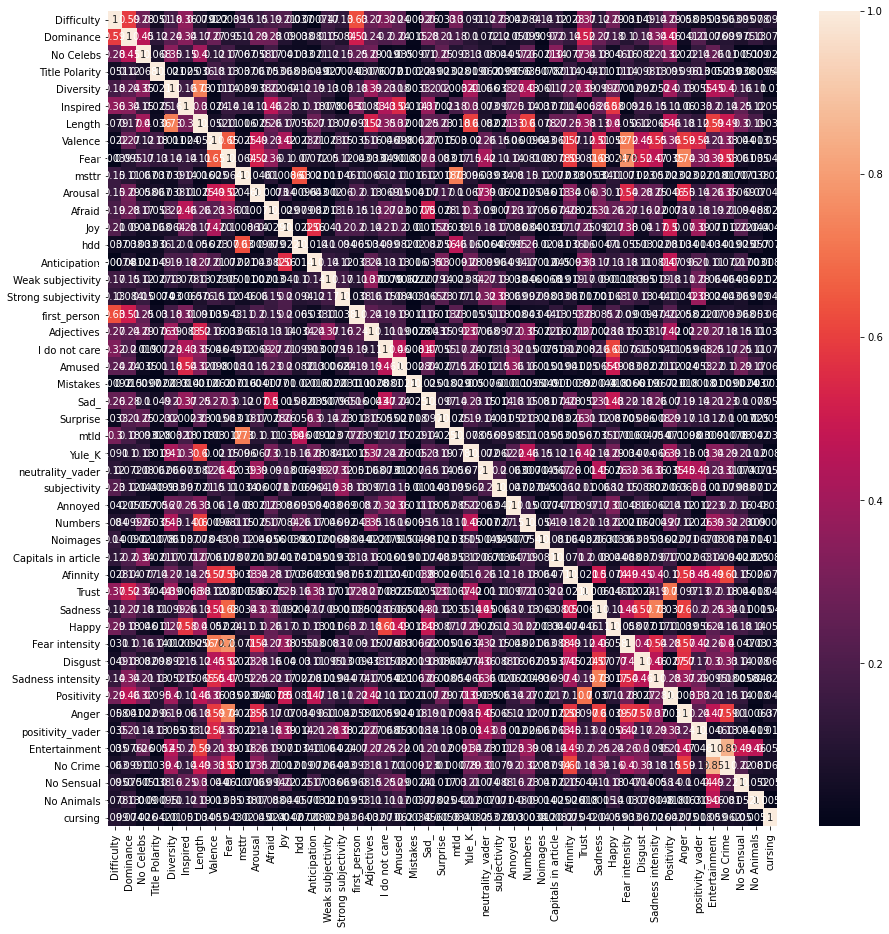

In [95]:
import math
import matplotlib.pyplot as plt
%matplotlib inline 

correlationMatrix = data[features].corr().abs()

plt.subplots(figsize=(15, 15))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)
plt.show()

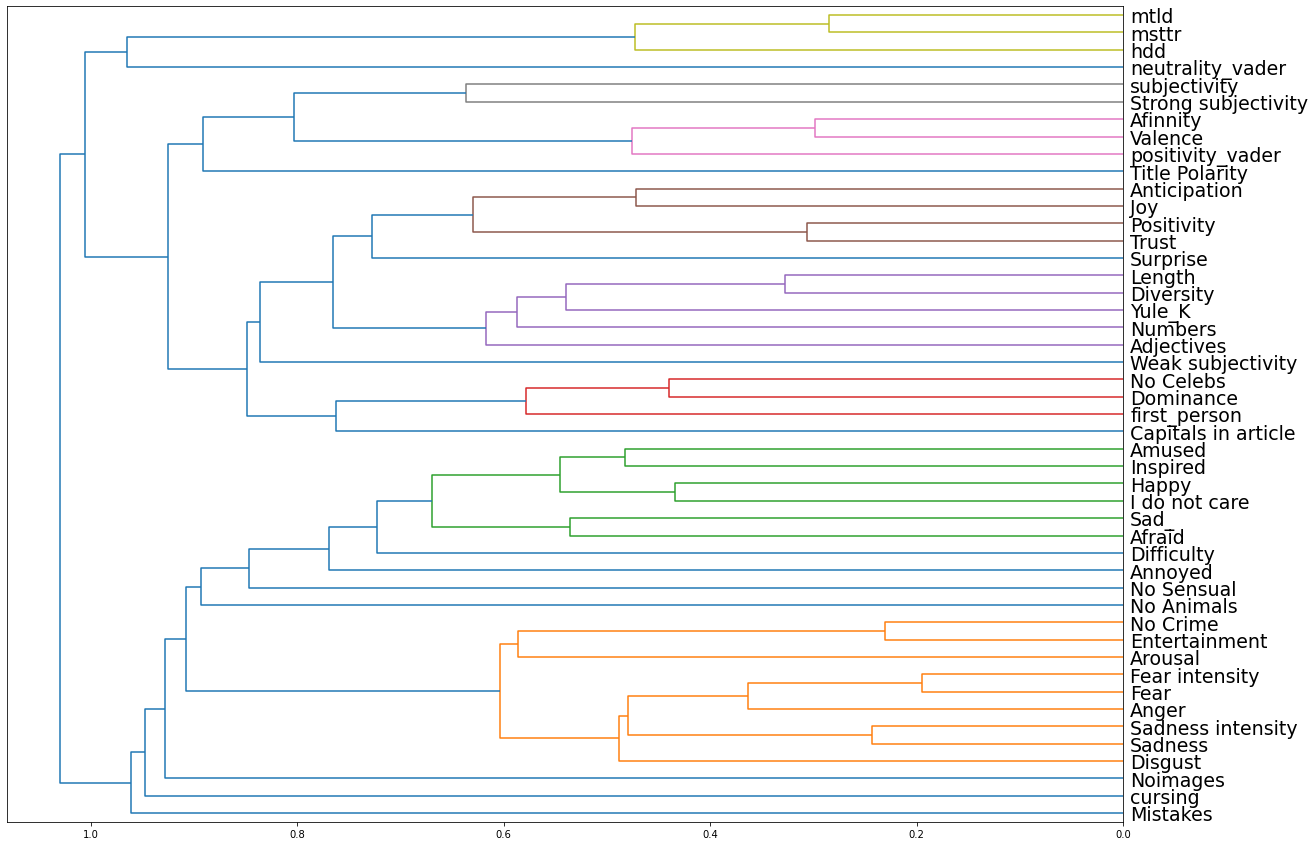

In [96]:
from scipy.cluster import hierarchy as hc
from scipy import linalg, optimize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

corr = np.round(scipy.stats.spearmanr(data[features]).correlation, 5)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=data[features].columns, orientation='left', leaf_font_size=19)
plt.show()

In [97]:
data.isnull().values.any()

False

In [98]:
data.isnull().sum().sum()

0

In [99]:
data.isnull().any()

Noimages          False
Length            False
Difficulty        False
uniq_wds          False
char_count        False
                  ...  
Fear intensity    False
Yule_K            False
Title Polarity    False
cursing           False
quality           False
Length: 73, dtype: bool

In [100]:
#nan_rows = data[data['Fear_intensity'].isnull()]
#nan_rows 

In [101]:
data = data.dropna()

In [102]:
# Model construction starts here

In [103]:
data.head()

Noimages  Length  Difficulty  uniq_wds  char_count  avg_word  perc_uniq  \
0         2   361.0        47.0     225.0      2135.0  5.030137   0.623269   
1         2   362.0        56.0     208.0      1959.0  4.560773   0.574586   
2         2   460.0        40.0     260.0      2782.0  5.154176   0.565217   
3         4  4761.0        54.0    1702.0     27720.0  4.986622   0.357488   
4         6  5232.0        57.0    1837.0     30425.0  4.966983   0.351109   

   Sentence length  stopwords  Mistakes  #links  Numbers  first_person  \
0         5.030137      128.0  1.000000   False     10.0    434.903047   
1         4.560773      147.0  0.998682   False      5.0    378.453039   
2         5.154176      155.0  0.996929   False      6.0    419.565217   
3         4.986622     1902.0  0.999961   False     22.0    384.373031   
4         4.966983     1909.0  0.999327   False     28.0    352.637615   

        mtld     msttr       hdd  Capitals in article      Anger  Positivity  \
0  13.293714  0.538571  0.409306                  0.0  10.222222    6.666667   
1  13.152308  0.535789  0.402516                  0.0   2.403846   12.500000   
2  13.548471  0.542018  0.404266                  0.0  13.076923   13.846154   
3  13.249959  0.534646  0.395009                  0.0   5.170388   20.387779   
4  13.333190  0.536591  0.395576                  1.0   4.463800   13.881328   

        Joy   Disgust  Surprise      Trust  Anticipation    Sadness  \
0  3.111111  4.888889  2.222222   4.444444      4.000000  11.111111   
1  3.365385  2.884615  1.923077  10.576923      3.365385   3.846154   
2  4.230769  6.538462  2.307692  11.923077      3.846154   7.692308   
3  9.224442  4.465335  2.761457  17.978848     13.572268   9.224442   
4  3.157322  5.008165  4.082744   8.219924      7.131192   5.661404   

    negative       Fear    density       Sad_      Happy   Inspired  \
0  16.444444  12.444444  23.111111   5.333333   9.333333   6.222222   
1   6.250000   6.730769  18.750000   5.288462   8.173077   9.615385   
2  18.076923  20.384615  31.923077   5.384615   6.923077   3.846154   
3  13.689777  10.047004  34.077556  11.104583  18.037603  19.330200   
4  16.113228   9.254219  29.994556   9.308655  17.964072  16.766467   

   I do not care   Annoyed     Amused     Afraid  Polarity  negativity_vader  \
0       6.666667  3.111111   5.777778   4.444444    0.9988             0.269   
1       5.769231  2.884615   6.730769   9.615385    0.9336             0.102   
2       3.461538  3.461538   4.615385   6.923077    0.9986             0.238   
3      13.454759  8.578143  16.157462  14.218566    0.9999             0.142   
4      14.044638  6.205770  14.589004  14.643440    0.9998             0.108   

   neutrality_vader  positivity_vader  subjectivity  No Celebs  Adjectives  \
0             0.681             0.050      0.380064        0.0    0.111111   
1             0.833             0.065      0.267697        0.0    0.096154   
2             0.679             0.084      0.411460        1.0    0.173077   
3             0.773             0.085      0.374820        0.0    0.216216   
4             0.826             0.067      0.367329        1.0    0.219924   

    cadence  No Animals  No Crime  No Sensual  Entertainment  Diversity  \
0  0.365385         0.0       6.0         1.0            7.0        1.0   
1  0.365385         0.0       2.0         0.0            2.0        1.0   
2  0.365385         2.0      14.0         0.0           17.0        7.0   
3  0.019231         2.0      11.0         6.0           19.0       11.0   
4  0.038462        28.0      24.0         6.0           59.0       14.0   

  Total Interactions  Likes  Comments  Shares  Love    Wow   Haha    Sad  \
0                677  182.0     131.0    94.0   2.0  137.0   94.0   30.0   
1                971  520.0      63.0   115.0  90.0    3.0  175.0    0.0   
2                591   64.0     202.0    65.0   8.0   11.0   23.0   16.0   
3                693  133.0     116.0   122.0   2

In [104]:
X = data[features]
y = data['quality']

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [106]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((51132, 47), (12784, 47), (51132,), (12784,))

# Study the Decision Tree Classifier

In [107]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RepeatedKFold

In [108]:
estimator = DecisionTreeClassifier(criterion='gini', splitter='best', 
max_depth=8, min_samples_split=500, min_samples_leaf=500, 
min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)

In [109]:
estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [110]:
val_pred_probs = estimator.predict_proba(X_val)

val_pred = estimator.predict(X_val)

In [111]:
f1_score(y_val, val_pred, average='macro')

0.8467673382340708

In [112]:
leave_id = estimator.apply(X_val)
print("The number of nodes is ", estimator.tree_.node_count)

The number of nodes is  119


In [113]:
dataplus = pd.concat([X_val.reset_index(),y_val.reset_index(),pd.DataFrame(val_pred_probs, columns=['prob0', 'prob1'])['prob1'], pd.DataFrame(leave_id, columns=['node'])], axis = 1) #.columns =['prob', 'node']

In [114]:
dataplus.shape

(12784, 52)

In [115]:
#saving the tree https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
from graphviz import Source
from sklearn import tree
#Source( tree.export_graphviz(estimator, out_file=None, feature_names=X.columns))

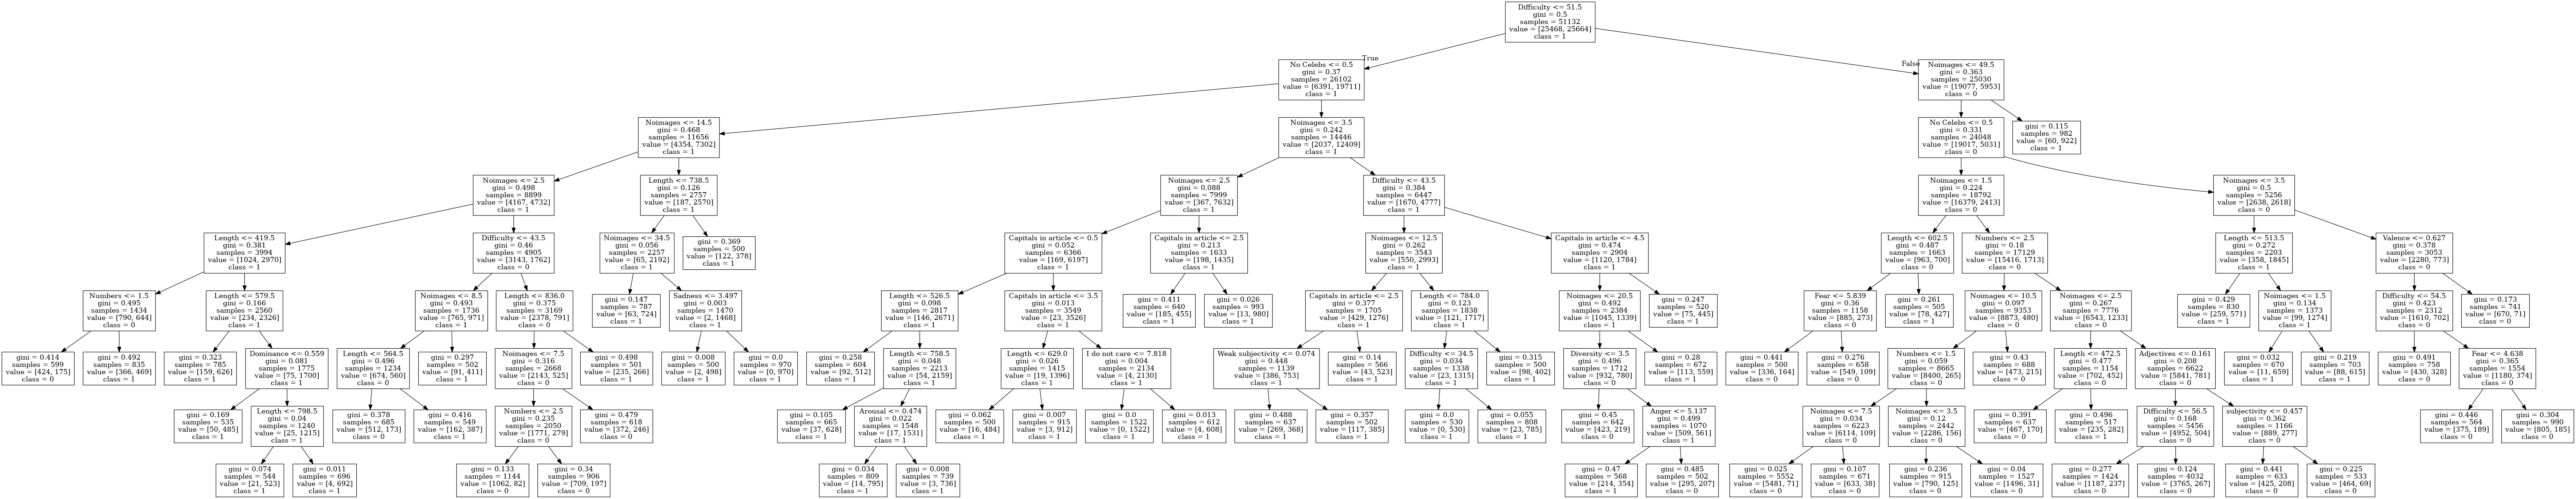

In [116]:
graph = Source( tree.export_graphviz(estimator, out_file=None, feature_names=X.columns, class_names=["0", "1"]))
png_bytes = graph.pipe(format='png')
with open('tree_pipe4.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

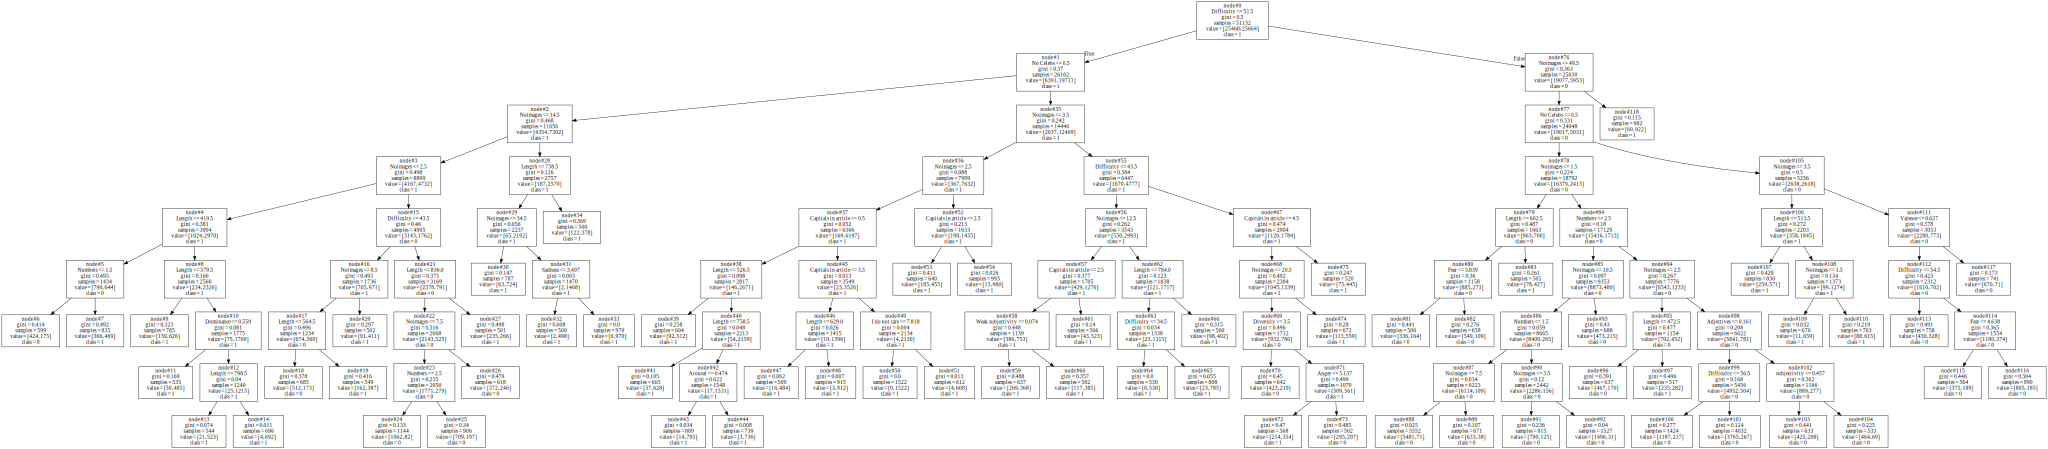

In [117]:
# visualizing our decision tree with max_depth = 2
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(estimator)
graphviz.Source(export_graphviz(estimator,
                                out_file=None,
                                feature_names=features,
                                class_names=["0", "1"],
                                node_ids = True,
                                impurity=True))


# Study now the Random Forest Classifier

In [118]:
rf = RandomForestClassifier()

In [119]:
#Get the best RF Classifier from the grid

In [120]:
rf = RandomForestClassifier()
grid = {'min_samples_leaf' : [15, 20], 'max_features' : ['auto'], 
        'min_samples_split' : [   40, 60]
       }
clf = GridSearchCV(rf, grid, cv=5)
clf.fit(X_train, y_train)
#best_clf = clf.best_estimator_

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [121]:
clf_val_pred_probs = clf.predict_proba(X_val)

clf_val_pred = clf.predict(X_val)

In [122]:
# Get the f1 Score of the best RF classifier of the grid

f1_score(y_val, clf_val_pred, average='macro')

0.8874477429599552

In [123]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [124]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6490
           1       0.89      0.88      0.88      6294

    accuracy                           0.89     12784
   macro avg       0.89      0.89      0.89     12784
weighted avg       0.89      0.89      0.89     12784



# Lets Try a RF classifier selecting manually the parameters

In [125]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf.fit(X_train, y_train)

val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

In [126]:
train_pred_probs = rf.predict_proba(X_train)
train_pred = rf.predict(X_train)


In [127]:
log_loss(y_val, val_pred_probs, labels=rf.classes_)

0.3102548151157348

In [128]:
log_loss(y_train, train_pred_probs, labels=rf.classes_)

0.2563594848224626

In [129]:
f1_score(y_val, clf_val_pred, average='macro')

0.8874477429599552

In [130]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

Importance
Noimages               0.204917
Difficulty             0.190023
Dominance              0.099504
No Celebs              0.077357
Capitals in article    0.042108
first_person           0.037384
Length                 0.036354
Diversity              0.026250
Inspired               0.026219
Numbers                0.020571
Adjectives             0.015080
Title Polarity         0.014260
Trust                  0.014136
Joy                    0.013096
Valence                0.011834
Weak subjectivity      0.011620
Afraid                 0.010115
I do not care          0.010108
Positivity             0.009889
Fear                   0.009412

f1_score(y_val, val_pred, average='macro')

In [131]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

Importance
Noimages               0.204917
Difficulty             0.190023
Dominance              0.099504
No Celebs              0.077357
Capitals in article    0.042108
first_person           0.037384
Length                 0.036354
Diversity              0.026250
Inspired               0.026219
Numbers                0.020571
Adjectives             0.015080
Title Polarity         0.014260
Trust                  0.014136
Joy                    0.013096
Valence                0.011834
Weak subjectivity      0.011620
Afraid                 0.010115
I do not care          0.010108
Positivity             0.009889
Fear                   0.009412

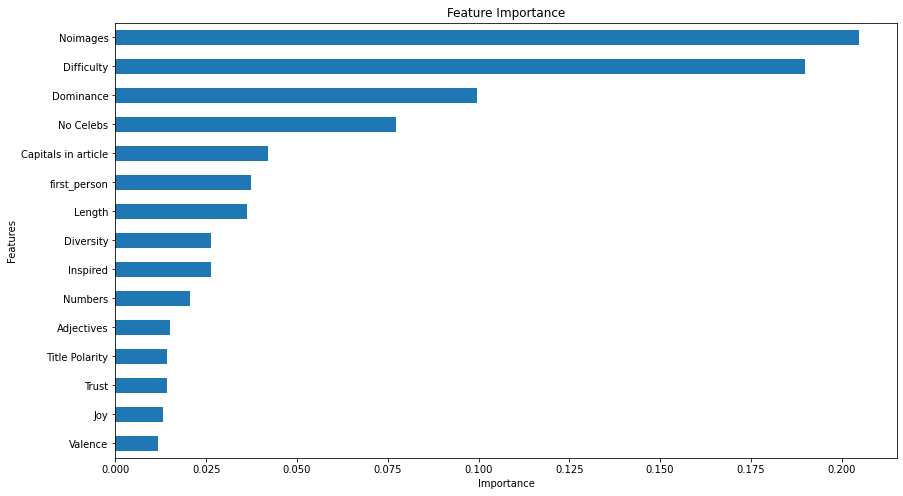

In [132]:
import matplotlib.pyplot as plt

plot = fi.sort_values(by = 'Importance', ascending=True).tail(15).plot.barh(figsize = (14,8), legend = False, title = 'Feature Importance', 
                                                                           )

#plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

fig = plot.get_figure()
#fig.savefig('Importance_News_75.png')



In [133]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[5821  669]
 [ 756 5538]]


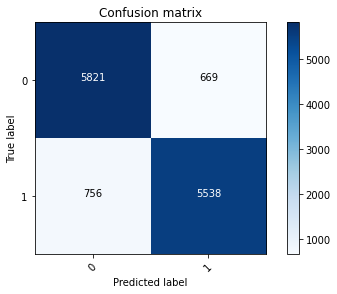

In [134]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [135]:
# Check AGAIN the accurance of the manually defined RF classifier

f1_score(y_val, val_pred, average='macro')

0.8884778893972252

In [136]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6490
           1       0.89      0.88      0.88      6294

    accuracy                           0.89     12784
   macro avg       0.89      0.89      0.89     12784
weighted avg       0.89      0.89      0.89     12784



In [137]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Total number of Trees {int(len(rf.estimators_))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Total number of Trees 2000
Average number of nodes 1870
Average maximum depth 21


In [138]:
# visualizing the nth tree of the Random Forest (n=0)
import graphviz
from sklearn.tree import export_graphviz

#dot_data = export_graphviz(rf.estimators_[0])
graphviz.Source(export_graphviz(rf.estimators_[10],
                                out_file=None,
                                feature_names=features,
                                class_names=["0", "1"],
                                node_ids = True,
                                impurity=True))

In [139]:
MAX_ROUNDS = 180
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.1
EARLY_STOPPING_ROUNDS = 55  
# Note: I set EARLY_STOPPING_ROUNDS high so that (when OPTIMIZE_ROUNDS is set)
#       I will get lots of information to make my own judgment.  You should probably
#       reduce EARLY_STOPPING_ROUNDS if you want to do actual early stopping.

In [140]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#from numba import jit
import time
import gc

In [141]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
#@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]



In [142]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [143]:
fit_model_xgb = model.fit(X_train,y_train)

In [144]:
val_pred_xgb = fit_model_xgb.predict(X_val)

Confusion matrix, without normalization
[[5895  595]
 [ 422 5872]]


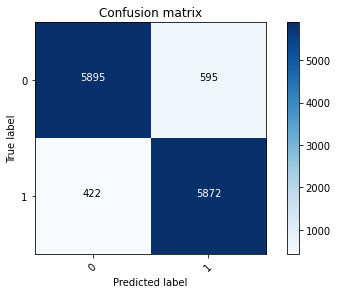

In [145]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred_xgb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [146]:
f1_score(y_val, val_pred_xgb, average='macro')

0.9204471767925628

In [147]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6490
           1       0.89      0.88      0.88      6294

    accuracy                           0.89     12784
   macro avg       0.89      0.89      0.89     12784
weighted avg       0.89      0.89      0.89     12784



In [148]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_val, clf_val_pred))


Accuracy :  0.8875156445556946


In [149]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

In [150]:

clf = SGDClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
valid_score = clf.score(X_val, y_val)
print(f'\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')



Train score: 0.81 ; Validation score: 0.81



In [151]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [152]:
clf = SGDClassifier()

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

In [154]:
random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'eta0': 0.0010441769933850781, 'learning_rate': 'invscaling', 'loss': 'hinge'}
Best score: 0.8113704474629702


In [155]:
import eli5

In [156]:
eli5.show_prediction(rf, X_val[features].iloc[0], show_feature_values=True)

In [367]:
eli5.show_prediction(rf, X_val[features].iloc[1], show_feature_values=True)

In [158]:
eli5.explain_prediction(rf, data[features].iloc[1])

Explanation(estimator="RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=None, max_features='auto',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=20, min_samples_split=40,\n                       min_weight_fraction_leaf=0.0, n_estimators=2000,\n                       n_jobs=1, oob_score=False, random_state=None, verbose=0,\n                       warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.4981290287882355, std=None, value=1.0), FeatureWeight(feature='Difficulty', weight=0.12793888334175907, std=None, value=56.0), FeatureWeight(feature='No Celebs', weight=0.06555343425522199, std=None, value=0.0), FeatureWeight(feature='Length', weight=0.05204615982437785, std=None, value=362.0), FeatureWeight(feature='Dominance', weight=0.052028449706208825, std=None, value=0.5464869565217391), FeatureWeight(feature='Diversity', weight=0.041094063566541626, std=None, value=1.0), FeatureWeight(feature='Adjectives', weight=0.030506546991725197, std=None, value=0.09615384615384616), FeatureWeight(feature='Title Polarity', weight=0.021028121509205962, std=None, value=-0.05), FeatureWeight(feature='Capitals in article', weight=0.01246769571804452, std=None, value=0.0), FeatureWeight(feature='Mistakes', weight=0.009017653938738587, std=None, value=0.9986817822304244), FeatureWeight(feature='Sadness intensity', weight=0.006773623534649153, std=None, value=0.1867586206896552), FeatureWeight(feature='Yule_K', weight=0.003503973452506759, std=None, value=376.2355191837603), FeatureWeight(feature='Fear', weight=0.0028917363056671663, std=None, value=6.730769230769233), FeatureWeight(feature='Annoyed', weight=0.0019642309333213065, std=None, value=2.8846153846153846), FeatureWeight(feature='Afraid', weight=0.0017406462632608333, std=None, value=9.615384615384617), FeatureWeight(feature='No Animals', weight=0.0012888636633828275, std=None, value=0.0), FeatureWeight(feature='Surprise', weight=0.0009115039311043153, std=None, value=1.9230769230769231), FeatureWeight(feature='positivity_vader', weight=0.0008539152737189416, std=None, value=0.065), FeatureWeight(feature='Afinnity', weight=0.0006519555341580758, std=None, value=-26.0)], neg=[FeatureWeight(feature='first_person', weight=-0.051285079970500025, std=None, value=378.4530386740331), FeatureWeight(feature='Numbers', weight=-0.05090072221429078, std=None, value=5.0), FeatureWeight(feature='Noimages', weight=-0.029079529035104437, std=None, value=2.0), FeatureWeight(feature='Inspired', weight=-0.017898356110875775, std=None, value=9.615384615384617), Feat

In [159]:
eli5.explain_weights(rf)

Explanation(estimator="RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=None, max_features='auto',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=20, min_samples_split=40,\n                       min_weight_fraction_leaf=0.0, n_estimators=2000,\n                       n_jobs=1, oob_score=False, random_state=None, verbose=0,\n                       warm_start=False)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='x30', weight=0.20491711044087824, std=0.05653476899216919, value=None), FeatureWeight(feature='x0', weight=0.19002302489893563, std=0.1237967135822836, value=None), FeatureWeight(feature='x1', weight=0.09950354735508386, std=0.09963449701059579, value=None), FeatureWeight(feature='x2', weight=0.07735677363582086, std=0.07825806864170796, value=None), FeatureWeight(feature='x31', weight=0.04210766535607385, std=0.03519833976310594, value=None), FeatureWeight(feature='x17', weight=0.03738439733188651, std=0.05120767872113243, value=None), FeatureWeight(feature='x6', weight=0.036354195827973966, std=0.024075982925553255, value=None), FeatureWeight(feature='x4', weight=0.026249565112539414, std=0.02331046033405858, value=None), FeatureWeight(feature='x5', weight=0.02621935710429374, std=0.02792194235617528, value=None), FeatureWeight(feature='x29', weight=0.020570804325357895, std=0.013014348968187645, value=None), FeatureWeight(feature='x18', weight=0.015080114499202166, std=0.015312272118318931, value=None), FeatureWeight(feature='x3', weight=0.014259838940450192, std=0.013767639496629815, value=None), FeatureWeight(feature='x33', weight=0.01413561208966351, std=0.02364565789288258, value=None), FeatureWeight(feature='x12', weight=0.01309570862826359, std=0.011269215033168054, value=None), FeatureWeight(feature='x7', weight=0.011834441938371087, std=0.008189753059463862, value=None), FeatureWeight(feature='x15', weight=0.011620433764941025, std=0.006209590891361506, value=None), FeatureWeight(feature='x11', weight=0.010115282744330278, std=0.01114737550277405, value=None), FeatureWeight(feature='x19', weight=0.010108269471709772, std=0.009709704023374807, value=None), FeatureWeight(feature='x39', weight=0.009889414100130193, std=0.016103270563759306, value=None), FeatureWeight(feature='x8', weight=0.00941201488967911, std=0.005517527753626677, value=None)], remaining=27), decision_tree=None, highlight_spaces=None, transition_features=None)

In [160]:
eli5.show_weights(fit_model_xgb, top = 10,feature_names = features)

In [161]:
eli5.show_weights(rf, top = 10,feature_names = features)

http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/

In [207]:
from treeinterpreter import treeinterpreter as ti

In [208]:
prediction, bias, contributions = ti.predict(rf, X_val[features])


MemoryError: Unable to allocate 17.5 GiB for an array with shape (2000, 12784, 46, 2) and data type float64

In [ ]:
prediction

In [ ]:
prediction1, bias1, contributions1 = ti.predict(rf, X_val[features])


In [ ]:
L = []

for pred, bias, contr in zip(prediction1, bias1, contributions1):
    d = {"pred0" : round(pred[0],2)}
    for c, feature in zip(contr,features):
       d.update({feature:round(c[0],2)})
#      print(feature, round(c[0],2))
    L.append(d)
ContributionsClass_df = pd.DataFrame(L)   


In [ ]:
plot = ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().reindex(ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().
           abs().sort_values(ascending=True).index).plot(kind='barh', figsize=(10,10))
fig = plot.get_figure()
#fig.savefig('Importance_News_tree for Class 0_75.png')

In [ ]:
import matplotlib.pyplot as plt


plot = ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().reindex(ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().
           abs().sort_values(ascending=True).index).tail(10).plot(kind='barh', figsize=(5,4),color= 'grey')

plt.xlabel('Importance')
plt.ylabel('Features')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
fig = plot.get_figure()
fig.savefig('Baseline.png', dpi=1000, bbox_inches='tight')
#fig.savefig('Importance_News_tree for Class 75.png')

In [ ]:
L = []

for pred, bias, contr in zip(prediction1, bias1, contributions1):
    d = {"pred1" : round(pred[1],2)}
    for c, feature in zip(contr,features):
       d.update({feature:round(c[1],2)})
#      print(feature, round(c[0],2))
    L.append(d)
ContributionsClassOne_df = pd.DataFrame(L)   


In [ ]:
ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().abs().sort_values(ascending=False).index)

In [ ]:
plot = ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().
           abs().sort_values(ascending=True).index).plot(kind='barh', figsize=(10,10))
fig = plot.get_figure()
#fig.savefig('Importance_News_tree for Class 1_75.png')

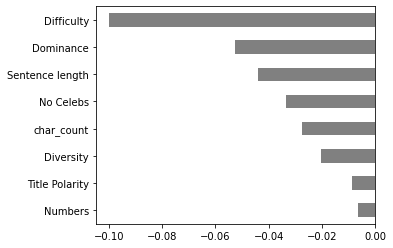

In [134]:
plot = ContributionsClassOne_df[ContributionsClassOne_df['pred1']<0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().
           abs().sort_values(ascending=True).index).tail(10).plot(kind='barh', figsize=(5,4),color= 'grey')
fig = plot.get_figure()
fig.savefig('Importance_News_tree_small for Class 1_75.png')




# PREDICT OTHER DATASETS

In [370]:
new1 = pd.read_csv("../../FINAL/data/eleos.csv")

In [371]:
new1.columns

Index(['Length', 'Noimages', 'Difficulty', 'uniq_wds', 'char_count',
       'avg_word', 'perc_uniq', 'Sentence length', 'stopwords', 'Mistakes',
       'Numbers', 'first_person', 'rare', 'mtld', 'msttr', 'hdd',
       'Capitals in article', 'Anger', 'Positivity', 'Joy', 'Disgust',
       'Surprise', 'Trust', 'Anticipation', 'Sadness', 'negative', 'Fear',
       'density', 'Sad_', 'Happy', 'Inspired', 'I do not care', 'Annoyed',
       'Amused', 'Afraid', 'Polarity', 'negativity_vader', 'neutrality_vader',
       'positivity_vader', 'subjectivity', 'No Celebs', 'caps', 'Adjectives',
       'cadence', 'No Animals', 'No Crime', 'No Sensual', 'Entertainment',
       'Afinnity', 'Strong subjectivity', 'Weak subjectivity', 'Valence',
       'Arousal', 'Dominance', 'Anger intensity', 'Joy intensity',
       'Sadness intensity', 'Fear intensity', 'Diversity', 'Balance',
       'Lexical richness', 'Title Polarity', 'cursing', 'quality'],
      dtype='object')

In [372]:
new1.columns

Index(['Length', 'Noimages', 'Difficulty', 'uniq_wds', 'char_count',
       'avg_word', 'perc_uniq', 'Sentence length', 'stopwords', 'Mistakes',
       'Numbers', 'first_person', 'rare', 'mtld', 'msttr', 'hdd',
       'Capitals in article', 'Anger', 'Positivity', 'Joy', 'Disgust',
       'Surprise', 'Trust', 'Anticipation', 'Sadness', 'negative', 'Fear',
       'density', 'Sad_', 'Happy', 'Inspired', 'I do not care', 'Annoyed',
       'Amused', 'Afraid', 'Polarity', 'negativity_vader', 'neutrality_vader',
       'positivity_vader', 'subjectivity', 'No Celebs', 'caps', 'Adjectives',
       'cadence', 'No Animals', 'No Crime', 'No Sensual', 'Entertainment',
       'Afinnity', 'Strong subjectivity', 'Weak subjectivity', 'Valence',
       'Arousal', 'Dominance', 'Anger intensity', 'Joy intensity',
       'Sadness intensity', 'Fear intensity', 'Diversity', 'Balance',
       'Lexical richness', 'Title Polarity', 'cursing', 'quality'],
      dtype='object')

 'Difficulty', 'Dominance', #'Sentence length', 
           'No Celebs', #'uniq_wds',
       #'char_count', #'avg_word', 
           'Title Polarity', 'Diversity', 'Inspired',
       'Length', 
           'Valence', 'Fear', #'perc_uniq', 
           'msttr', 'Arousal', 'Afraid',
       'Joy', #'Joy intensity', 
           'hdd', 'Anticipation', 'Weak subjectivity',
       'Strong subjectivity', 'first_person', 'Adjectives', 'I do not care',
       'Amused', 'Mistakes', #'stopwords', 
           'Sad_', 'Surprise', 'mtld', 'Yule_K',
       'neutrality_vader', 'subjectivity', 'Annoyed', 'Numbers', 'Noimages','Capitals in article',
       'Afinnity', 'Trust', 'Sadness', 'Happy', 'Fear intensity','Disgust',
       'Sadness intensity', 'Positivity', 'Anger', 
           'positivity_vader',
       #'density', 'negativity_vader', 'Anger intensity', 'Polarity',
       #'negative', 
           'Entertainment', 'No Crime', 'No Sensual', 'No Animals',
           'cursing'
           


In [373]:
#new1 = new1.drop(['perc_uniq', 'Anger intensity', 'Polarity', 'uniq_wds', 'avg_word', 
#                  'negativity_vader', 'negative', 'Joy intensity', 'density', 'stopwords'
#               ], axis = 1)

In [375]:
new1 = new1.rename(columns={'length':'Length','Lexical richness':'Yule_K',  })

In [376]:
new = new1[[ 'Difficulty', 'Dominance', #'Sentence length', 
           'No Celebs', #'uniq_wds',
       #'char_count', #'avg_word', 
           'Title Polarity', 'Diversity', 'Inspired',
       'Length', 
           'Valence', 'Fear', #'perc_uniq', 
           'msttr', 'Arousal', 'Afraid',
       'Joy', #'Joy intensity', 
           'hdd', 'Anticipation', 'Weak subjectivity',
       'Strong subjectivity', 'first_person', 'Adjectives', 'I do not care',
       'Amused', 'Mistakes', #'stopwords', 
           'Sad_', 'Surprise', 'mtld', 'Yule_K',
       'neutrality_vader', 'subjectivity', 'Annoyed', 'Numbers', 'Noimages','Capitals in article',
       'Afinnity', 'Trust', 'Sadness', 'Happy', 'Fear intensity','Disgust',
       'Sadness intensity', 'Positivity', 'Anger', 
           'positivity_vader',
       #'density', 'negativity_vader', 'Anger intensity', 'Polarity',
       #'negative', 
           'Entertainment', 'No Crime', 'No Sensual', 'No Animals',
           'cursing'    
] 
        ].copy()

In [377]:
new.columns

Index(['Difficulty', 'Dominance', 'No Celebs', 'Title Polarity', 'Diversity',
       'Inspired', 'Length', 'Valence', 'Fear', 'msttr', 'Arousal', 'Afraid',
       'Joy', 'hdd', 'Anticipation', 'Weak subjectivity',
       'Strong subjectivity', 'first_person', 'Adjectives', 'I do not care',
       'Amused', 'Mistakes', 'Sad_', 'Surprise', 'mtld', 'Yule_K',
       'neutrality_vader', 'subjectivity', 'Annoyed', 'Numbers', 'Noimages',
       'Capitals in article', 'Afinnity', 'Trust', 'Sadness', 'Happy',
       'Fear intensity', 'Disgust', 'Sadness intensity', 'Positivity', 'Anger',
       'positivity_vader', 'Entertainment', 'No Crime', 'No Sensual',
       'No Animals', 'cursing'],
      dtype='object')

In [378]:
X_testnew = new

In [379]:
y_pred_test = fit_model_xgb.predict(X_testnew)

In [380]:
print(classification_report(new1.quality, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       979
           1       0.76      0.72      0.74       956

    accuracy                           0.75      1935
   macro avg       0.75      0.75      0.75      1935
weighted avg       0.75      0.75      0.75      1935



In [381]:
f1_score(new1.quality, y_pred_test, average='macro')

0.75103712796403

In [382]:
new_prediction = y_pred_test
print("Prediction: {}".format(new_prediction))

Prediction: [0 0 1 ... 1 1 1]


In [384]:
eli5.show_prediction(fit_model_xgb, X_val[features].iloc[1], show_feature_values=True)

In [150]:
eli5.show_weights(fit_model_xgb, top = 10,feature_names = features)